<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/policygradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2022 6.884 Computational Sensorimotor Learning Assignment 2

In this assignment, we will implement model-free RL algorithms from scratch to solve `DoorKeyEnv5x5`.  We will cover:


* REINFORCE
* Vanilla Policy Gradient (VPG)
* Generalized Advantage Estimation (GAE)
* Proximal Policy Optimization (PPO)

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are (approximately) **150** total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Luis Costa Laveron

## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [1]:
!pip install gym-minigrid &>/dev/null

In [2]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd

In [3]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])
    
    return torch.tensor(images, device=device, dtype=torch.float)

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=5)
    
    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

In [5]:
class Config:
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=2000,
                gae_lambda=0.95,
                use_critic=False,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                use_gae=False):
        
        self.score_threshold = score_threshold
        self.discount = discount
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.log_interval = log_interval
        self.max_episodes = max_episodes
        self.use_critic = use_critic
        self.clip_ratio = clip_ratio
        self.target_kl = target_kl
        self.train_ac_iters = train_ac_iters
        self.gae_lambda=gae_lambda
        self.use_discounted_reward=use_discounted_reward
        self.entropy_coef = entropy_coef
        self.use_gae = use_gae

# Task (Environment)

In this assignment, we will work with the `DoorKeyEnv5x5` environment from [gym_miniworld](https://github.com/maximecb/gym-minigrid). This environment is a $5\times 5$ gridworld. The agent needs to pick up the key, open the door, and then go the the green cell. The agent gets a $+1$ reward if it reaches the green cell, and a $0$ reward otherwise.

The environment is visually shown below:

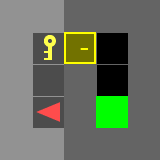

In [6]:
env = DoorKeyEnv5x5()

**Question**: What does `env.reset()` return? What does each item returned mean? What's the shape of the image in the observation? How about the action space? What does each action mean? (Hint: You may find the source code of gym_minigrid helpful.) (10 pts)

**Answer**: `env.reset()` resets the state of the grid world and returns a first observation. The observation comes in the form of a dictionary with the following items:

*   'direction' : the agent's direction/orientation (acting as a compass). This is an integer, where 0 is facing right, 1 is down, 2 is left and 3 is up.
*   'image' : a partially observable view of the environment. It is a 3D array with dimensions for width, height and channels (the channels have type, color and state information)
*   'mission' : a textual mission string (instructions for the agent)

* There are 7 available actions to the agent:
  * 0 : turn left
  * 1 : turn right
  * 2 : move forward 
  * 3 : pick up an object 
  * 4 : drop an object 
  * 5 : toggle/activate an object 
  * 6 : done completing task 




# Model

In policy gradients, we will directly learn a policy: i.e, for each state, predict an action!  We call this policy network the *actor*.

Our *actor* will take in as input the `DoorKeyEnv5x5` observation (a 7x7x3 image), and output a [Categorical distribution](https://pytorch.org/docs/stable/distributions.html#categorical) over all possible actions.  To choose an action, we will sample from this distribution.  We suggest implementing the actor network to contain a few convolutional layers followed by a few fully-connected layers.

In addition to the actor network, later questions in the PSET require estimating the value network, called the *critic*.  The critic estimates total future reward, much like DQN will in a future problem set, but is notably *on-policy*, meaning it's reward estimates are conditioned on the actor. We will use the critic to reduce variance in the policy gradient estimate. 

For now, fill in the **TODOS** to implement the actor-critic model below.  We suggest having separate actor and critic networks, as this has been shown to empirically improve performance.

As this will have to be correct for your policy gradients algorithms to work, we will not grade this code independently.

In [7]:
# class ACModel(nn.Module):
#     def __init__(self, num_actions, use_critic=False):
#         super().__init__()
#         self.use_critic = use_critic
#         self.num_actions = num_actions

#         ##### TODO: initialize actor and critic networks #######
#         self.layer_dict_actor = nn.ModuleDict()  

#         # Define actor's model
#         num_filters = 32
#         kernel_size = 3
#         out = torch.zeros((1,3,7,7)) # create dummy inputs to be used to infer shapes of layers
#         self.layer_dict_actor['convolution_1'] = nn.Conv2d(in_channels=out.shape[1], out_channels=num_filters,
#                                                           kernel_size=kernel_size, stride=1)
#         out = self.layer_dict_actor['convolution_1'].forward(out)
#         #self.layer_dict_actor['batchnorm_1'] = nn.BatchNorm2d(num_features=out.shape[1])
#         #out = F.leaky_relu(self.layer_dict_actor['batchnorm_1'].forward(out))
#         self.layer_dict_actor['convolution_2'] = nn.Conv2d(in_channels=out.shape[1], out_channels=num_filters,
#                                                           kernel_size=kernel_size, stride=1)
#         out = self.layer_dict_actor['convolution_2'].forward(out)
#         # self.layer_dict_actor['batchnorm_2'] = nn.BatchNorm2d(num_features=out.shape[1])
#         # out = F.leaky_relu(self.layer_dict_actor['batchnorm_2'].forward(out))

#         out = out.view(out.shape[0], -1)  # flatten outputs from (b, c, h, w) to (b, c*h*w)
#         self.layer_dict_actor['fully_connected'] = nn.Linear(in_features=out.shape[1],  # initialize the prediction output linear layer
#                                       out_features=self.num_actions)
#         out = self.layer_dict_actor['fully_connected'].forward(out)

#         # Define critic's model
#         if self.use_critic:
#           pass
#         else:
#           self.layer_dict_critic = nn.ModuleDict()

#         ########################################################

#         # Initialize parameters correctly (don't remove this!)
#         self.apply(init_params)

#     def forward(self, obs):
#         conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into expected order
#         dist, value = None, None
#         ##### TODO: produce Categorical action distribtuion and critic value output #####
#         ##### if self.use_critic is false, return all zeros for value ###################
#         out = self.layer_dict_actor['convolution_1'].forward(conv_in)
#         #out = F.leaky_relu(self.layer_dict_actor['batchnorm_1'].forward(out))
#         out = F.relu(out)
#         out = self.layer_dict_actor['convolution_2'].forward(out)
#         out = F.relu(out)
#         out = out.view(out.shape[0], -1)  # flatten outputs from (b, c, h, w) to (b, c*h*w)
#         #out = F.leaky_relu(self.layer_dict_actor['batchnorm_2'].forward(out))
#         out = self.layer_dict_actor['fully_connected'].forward(out)
#         probs = F.softmax(out,dim=1)
#         dist = torch.distributions.categorical.Categorical(probs=probs)
#         if self.use_critic:
#           pass
#         else:
#           value = 0
#         ##################################################################################

#         return dist, value

class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=False):
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into expected order

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)

        return dist, value

# Model Evaluation

The following code runs the actor critic model `acmodel` for one episode, and returns a dictionary with all the relevant information from the rollout.  It relies on placeholders below for `compute_advantage_gae` and `compute_discounted_return`: you can ignore these for now, and just evaluate through to the next section.  However, it might be useful to review this code just to make sure you understand what's going on.

In [47]:
def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    advantages = torch.zeros_like(values)
    #### TODO: populate GAE in advantages over T timesteps (10 pts) ############
    # print("advantages shape", advantages.shape)
    # print("gae_lambda: ", gae_lambda)
    # print("T: ", T)
    # N = len(rewards)
    # for t in range(N):
    #   total = 0 
    #   for k in range(1,T+1):
    #     R = rewards[t] + sum([rewards[i]*discount**(i-t) for i in range(t+1,t+k)])
    #     R += values[t+k]*discount**(k)
    #     total += gae_lambda*R

    #   advantages[t] = R - values[t]

    deltas = torch.zeros_like(values)
    for t in range(len(rewards)-1):
      deltas[t] = rewards[t] + discount*values[t+1] - values[t]
    deltas[-1] = rewards[-1]
    for t in range(T):
      for l in range(t,len(deltas)):
        advantages[t] += ((discount*gae_lambda)**(l-t))*deltas[l]

    
    ############################################################################
    
    return advantages[:T]

In [44]:
def compute_discounted_return(rewards, discount, device=None):
    returns = torch.zeros(*rewards.shape, device=device)

    #### TODO: populate discounted reward trajectory (10 pts) ############
    returns = []
    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + discount**pw * r
            pw = pw + 1
        returns.append(Gt)
        
    returns = torch.tensor(returns)
    ######################################################################
    return returns

In [45]:
def collect_experiences(env, acmodel, args, device=None):
    """Collects rollouts and computes advantages.
    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """


    MAX_FRAMES_PER_EP = 300
    shape = (MAX_FRAMES_PER_EP, )

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros(*shape, device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    obss = [None]*MAX_FRAMES_PER_EP

    obs = env.reset()

    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction

        preprocessed_obs = preprocess_obss(obs, device=device)
        
        with torch.no_grad():
            dist, value = acmodel(preprocessed_obs)
        action = dist.sample()[0]


        obss[T] = obs
        obs, reward, done, _ = env.step(action.item())


        # Update experiences values
        #print()
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        log_probs[T] = dist.log_prob(action)


        total_return += reward
        T += 1

        if done:
            break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)
    exps = dict(
        obs = preprocess_obss([
            obss[i]
            for i in range(T)
        ], device=device),
        action = actions[:T],
        value  = values[:T],
        reward = rewards[:T],
        advantage = discounted_reward-values[:T],
        log_prob = log_probs[:T],
        discounted_reward = discounted_reward,
        advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount)
    )

    logs = {
        "return_per_episode": total_return,
        "num_frames": T
    }

    return exps, logs

# REINFORCE

Now comes the fun part!  Using the `collect_experiences` function and `ACModel`, we will implement vanilla policy gradients.  The following function takes in an `optimizer`, `ACModel`, batch of experience `sb`, and some arguments `args` (see `Config` in setup for fields and default values), and should perform a policy gradients parameter update using the observed experience.

Fill in todos below to implement vanilla policy gradients (20 pts).

In [11]:
def update_parameters_reinforce(optimizer, acmodel, sb, args):
    def _compute_policy_loss(logps, returns):
        policy_loss = torch.tensor(0)

        #### TODO: complete policy loss (10 pts) ###
        # print("logps : ", logps)
        # print("returns: ", returns)
        policy_loss = (logps*returns).sum()*-1 #-1 for gradient ascent?
        ############################################

        return policy_loss


    logps, reward = None, None
    
    ### TODO: compute logps and reward from acmodel, sb['obs'], sb['action'], and sb['reward'] ###
    ### If args.use_discounted_reward is True, use sb['discounted_reward'] instead. ##############
    ### (10 pts) #########################################
    dist, value = acmodel.forward(sb['obs'])
    actions = sb['action']
    logps = dist.logits
    logps = logps.gather(1, actions.long().unsqueeze(1)).reshape(-1)
    if args.use_discounted_reward:
      reward = sb['discounted_reward']
    else:
      reward = sb['reward']
      reward = torch.flip(torch.cumsum(torch.flip(reward,dims=[0]),dim=0),dims=[0])

    #reward = np.cumsum(reward[::-1])[::-1] 
    ##############################################################################################

    policy_loss = _compute_policy_loss(logps, reward)
    update_policy_loss = policy_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    policy_loss.backward()
    
    # Perform gradient clipping for stability
    for p in acmodel.parameters():
        if p.grad is None:
            print("Make sure you're not instantiating any critic variables when the critic is not used")
    update_grad_norm = sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values
    logs = {
        "policy_loss": update_policy_loss,
        "grad_norm": update_grad_norm
    }

    return logs

Now, let's try to run our implementation.  The following experiment harness is written for you, and will run sequential episodes of policy gradients until `args.max_episodes` timesteps are exceeded or the rolling average reward (over the last 100 episodes is greater than `args.score_threshold`. It is expected to get highly variable results, and we'll visualize some of this variability at the end.

The method accepts as arguments a `Config` object `args`, and a `parameter_update` method (such as `update_parameters_reinforce`).

In [37]:
def run_experiment(args, parameter_update):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = DoorKeyEnv5x5()

    acmodel = ACModel(env.action_space.n, use_critic=args.use_critic)
    acmodel.to(device)

    is_solved = False
    
    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW
    
    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes))
    for update in pbar:
        exps, logs1 = collect_experiences(env, acmodel, args, device)
        logs2 = parameter_update(optimizer, acmodel, exps, args)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]
        
        rewards.append(logs["return_per_episode"])
        
        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"]}
        
        if args.use_critic:
            data['value_loss'] = logs["value_loss"]

        pd_logs.append(data)

        pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break

    if is_solved:
        print('Solved!')
    
    return pd.DataFrame(pd_logs).set_index('episode')


## Run Reinforce

Great!  Now let's run our implementation, and see how we do.

  0%|          | 0/2000 [00:00<?, ?it/s]

Solved!


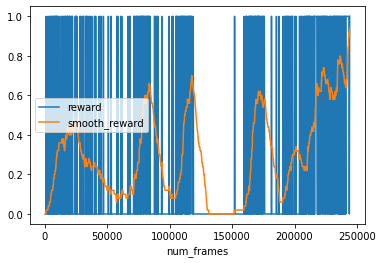

In [54]:
args = Config()
#args.max_episodes = args.max_episodes // 2 #delete later
#args.lr = 1e-4
df = run_experiment(args, update_parameters_reinforce)
df.plot(x='num_frames', y=['reward','smooth_reward'])

## REINFORCE with Discounted Reward

Uh oh! Even after 300,000 steps, our policy does not converge. One reason for failure is the way rewards are generated in the real-world. In an ideal world, the agent would be rewarded at every timestep in a manner that perfectly corresponded to the quality of the action taken in a particular state.  However, this is rarely the case; for example, in Doorkey we only get reward at the very end of the episode (i.e., the sparse reward scenario).

In DQN, we tackle this with a discount factor `gamma` on future rewards.  In policy gradients, we'll simply rewrite all of our step rewards to be discounted from the past episode reward.

Fill in `compute_discounted_return` code block above, then run code cell below to see the effect of discounted reward trajectories.  This should converge, so if it doesn't, you've made an error (although try re-running the cell a few times first to make sure it's not a bad random seed). (10 pts)



  0%|          | 0/2000 [00:00<?, ?it/s]

Solved!


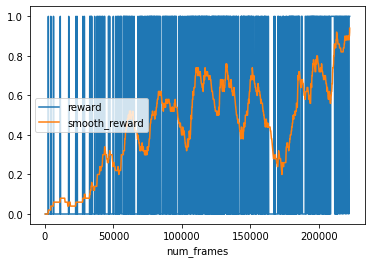

In [52]:
args = Config(use_discounted_reward=True)
#args.max_episodes = args.max_episodes // 2 #delete later
#args.lr = 1e-4
df = run_experiment(args, update_parameters_reinforce)
df.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Vanilla Policy Gradients

You may have noticed that the REINFORCE training curve is extremely unstable. It's time to bring in our *critic*!  We can prove from the Expected Grad-Log-Prob (EGLP) lemma that we can subtract any function $b(x)$ from our reward without changing our policy in expectation:

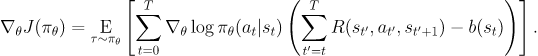

### Baseline Proof

**Question**: Prove that adding a baseline doesn't change the policy in expectation using the EGLP lemma.  This can be a loose proof as long as you convey the intutition. (10 pts)

**Proof**: 

By the linearity of expectation we have
$$
\nabla_\theta J(\pi_\theta) = \mathbb{E}\left[\sum_{t=0}^T\nabla_\theta\log \pi_θ(a_t|s_t)\left(\sum_{t'=t}^TR(s_{t'},a_{t'},s_{t'+1})-b(s_t)\right)\right] \\
= \mathbb{E}\left[\sum_{t=0}^T\nabla_\theta\log \pi_θ(a_t|s_t)\left(\sum_{t'=t}^TR(s_{t'},a_{t'},s_{t'+1})\right)\right] - \mathbb{E}\left[\sum_{t=0}^T\nabla_\theta\log \pi_θ(a_t|s_t)b(s_t)\right]
= \mathbb{E}\left[\sum_{t=0}^T\nabla_\theta\log \pi_θ(a_t|s_t)\left(\sum_{t'=t}^TR(s_{t'},a_{t'},s_{t'+1})\right)\right] - \sum_{t=0}^T\mathbb{E}\left[\nabla_\theta\log \pi_θ(a_t|s_t)b(s_t)\right]
$$
Therefore, to show that the expected value of the policy remains unchanged it suffices to show that 
$$
\mathbb{E}\left[\nabla_\theta\log \pi_θ(a_t|s_t)b(s_t)\right] = 0
$$
Using the definition of expectation we get that
$$
\mathbb{E}\left[\nabla_\theta\log \pi_θ(a_t|s_t)b(s_t)\right] = \int\nabla_\theta\log \pi_θ(a_t|s_t)b(s_t)\pi_θ(a_t|s_t)dθ \\
= b(s_t)\int\nabla_\theta\log \pi_θ(a_t|s_t)\pi_θ(a_t|s_t)dθ \quad\text{(b independent of $\theta$)} \\
= b(s_t)\int ∇_θ\pi_θ(a_t|s_t)dθ \quad\text{(derivative of log)} \\
=  b(s_t)∇_θ1 \quad\text{(distributions integrate to 1)} \\
= 0 
$$

Empirically, using the on-policy value function as the baseline ($b$) reduces variance in the policy gradient sample estimate, leading to faster and more stable learning.  We can estimate the $b$ using an L2 loss to the true rewards (or in our case, the discounted rewards), and constitutes an additional loss term in the overall objective. The baseline substracted return term, $R(s_{t'},a_{t'},s_{t' + 1}) - b(s_t)$ is already computed for you, and is referred to as the *advantage*.

In [50]:
def update_parameters_with_baseline(optimizer, acmodel, sb, args):
    def _compute_policy_loss_with_baseline(logps, advantages):
        ### TODO: implement the policy loss (5 pts) ##############
        returns = torch.flip(torch.cumsum(torch.flip(advantages,dims=[0]),dim=0),dims=[0])
        policy_loss = (logps*returns).sum()*-1
        #policy_loss = (logps*advantages).sum()*-1
        ##################################################
        
        return policy_loss
    
    def _compute_value_loss(values, returns):
        ### TODO: implement the value loss (5 pts) ###############
        returns = torch.flip(torch.cumsum(torch.flip(returns,dims=[0]),dim=0),dims=[0])
        value_loss = ((values-returns)**2).sum()
        ##################################################

        return value_loss

    logps, advantage, values, reward = None, None, None, None
    ### TODO: populate the policy and value loss computation fields using acmodel, sb['obs'], sb['action], and sb['discounted_reward']
    ### For the advantage term, use sb['advantage_gae'] if args.use_gae is True, and sb['advantage'] otherwise.
    ### 10 pts
    if args.use_gae:
      advantage = sb['advantage_gae'] 
    else:
      advantage = sb['advantage']

    dist, values = acmodel.forward(sb['obs'])
    actions = sb['action']
    logps = dist.logits
    logps = logps.gather(1, actions.long().unsqueeze(1)).reshape(-1)
    reward = sb['discounted_reward']     
    ####################################################################################################

    policy_loss = _compute_policy_loss_with_baseline(logps, advantage)
    value_loss = _compute_value_loss(values, reward)
    loss = policy_loss + value_loss

    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    loss.backward()
    update_grad_norm = sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
        "grad_norm": update_grad_norm
    }

    return logs

## Run REINFORCE with baseline

If you did everything right, you should be able to run the below cell to run the vanilla policy gradients implementation with baseline.  This should be somewhat more stable than without the baseline, and likely converge faster.


In [ ]:
args = Config(use_critic=True)
df_baseline = run_experiment(args, update_parameters_with_baseline)
df_baseline.plot(x='num_frames', y=['reward', 'smooth_reward'])

  0%|          | 0/2000 [00:00<?, ?it/s]

# Reinforce with GAE

The advantage we computed above seemed to work, and hopefully improved our results!  Fortunately, we can do even better.  The paper [Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438) describes a nifty method for building a strong advantage estimate (see formula 16 in the paper) that empirically outperforms a naive subtraction (and includes reward shaping).

Fill in the `compute_advantage_gae` method above according to the formula in the paper (10 pts), and then run the below cell.  GAE should further improve convergence time and stability.

In [49]:
args = Config(use_critic=True, use_gae=True)
df_gae = run_experiment(args, update_parameters_with_baseline)
df_gae.plot(x='num_frames', y=['reward', 'smooth_reward'])

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Proximal Policy Optimization

Our work is not yet done!  There are some surprisingly powerful additional tweaks we can make to our GAE implementation to further improve performance.

The current standard in policy gradients today is [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347), which improves on GAE by taking multiply policy update steps per minibatch, enabled by policy update clipping (this is a specific variant called *PPO-Clip*).  This leads to greater sample efficiency, as larger steps can be taken from the same data samples.

We've implemented most of PPO for you: all that's left for you are the policy and value loss computations (note that you'll have to evaluate the `acmodel` each time you compute them).  Note that for the policy loss, we also ask that you return the approximate KL divergence between the new and old action distributions notated as `approx_kl`; this is used to facilitate an early stopping condition in policy updates.

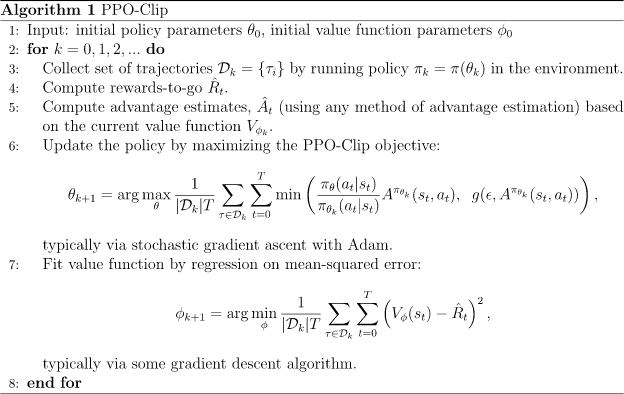

In [ ]:
def update_parameters_ppo(optimizer, acmodel, sb, args):
    def _compute_policy_loss_ppo(obs, old_logp, actions, advantages):
        policy_loss, approx_kl = 0, 0

        ### TODO: implement PPO policy loss computation (30 pts).  #######

        ##################################################################
        
        return policy_loss, approx_kl
    
    def _compute_value_loss(obs, returns):
        ### TODO: implement PPO value loss computation (10 pts) ##########

        ##################################################################

        return value_loss


    dist, _ = acmodel(sb['obs'])            
    old_logp = dist.log_prob(sb['action']).detach()
    
    advantage = sb['advantage_gae'] if args.use_gae else sb['advantage']

    policy_loss, _ = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
    value_loss = _compute_value_loss(sb['obs'], sb['discounted_reward'])

    for i in range(args.train_ac_iters):
        optimizer.zero_grad()
        loss_pi, approx_kl = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
        loss_v = _compute_value_loss(sb['obs'], sb['discounted_reward'])

        loss = loss_v + loss_pi
        if approx_kl > 1.5 * args.target_kl:
            break
        
        loss.backward(retain_graph=True)
        optimizer.step()
    
    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
    }

    return logs

In [ ]:
args = Config(use_critic=True, use_gae=True)
df_ppo = run_experiment(args, update_parameters_ppo)

df_ppo.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Fancy Plots

If you've gotten to this point, congrats: you've succesfully implemented REINFORCE, VPG, GAE, and PPO!  While we've been able to anecdotally compare their performance, we don't have any sense of *scientific rigor*.  Notably, given the variance you've likely seen between runs of these models, a single run may not reflect how strong a model really is.

For this problem, train each of these 4 methods using multiple seeds (at least 5, but more if you feel you need them).  Then, generate a high quality reward curve plot comparing each algorithm.  The plot should be clean and legible, and clearly demonstrate the performance and variance of each of the approaches.  As an example, see Figure 3 of the PPO paper (although we're only evaluating on a single environment).

Be creative and make something pretty: it matters for good science!

**Note:** you should leave a few hours for this to run.

In [ ]:
### TODO: generate your master comparison plot (30 pts)